# Функция передачи модуляции

In [400]:
import numpy as np
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

In [401]:
img1 = np.array(Image.open("1.png").rotate(5.71)).astype(np.float32)
img2 = np.array(Image.open("2.png").rotate(5.71)).astype(np.float32)
x = np.arange(0, 1500)

In [402]:
def calc_ESF(img):
    row = img[725][:, 0] / 255
    smooth = gaussian_filter(row, sigma=20)
    return smooth

In [403]:
def calc_MTF(lsf, xs):
    fft = np.fft.fft(lsf)
    fft_normalized = np.abs(fft) / np.max(np.abs(fft))

    MTF = np.abs(fft_normalized)

    freqs = np.fft.fftfreq(len(lsf))

    positive_mask = freqs >= 0
    freqs_positive = freqs[positive_mask]

    MTF_possitive = MTF[positive_mask]

    idx = np.argsort(freqs_positive)
    freqs_sorted = freqs_positive[idx]
    MTF_sorted = MTF_possitive[idx]

    return freqs_sorted, MTF_sorted

In [404]:
def center_and_shrink_ESF(esf):
    shrink_mask = (esf >= 0.1) & (esf <= 0.9)
    shrinked = esf[shrink_mask]
    xs = np.arange(-len(shrinked) // 2, len(shrinked) // 2)
    return shrinked, xs
    

In [405]:
def calc_LSF(esf):
    return np.gradient(esf)

In [406]:
esf1 = calc_ESF(img1)
esf2 = calc_ESF(img2)

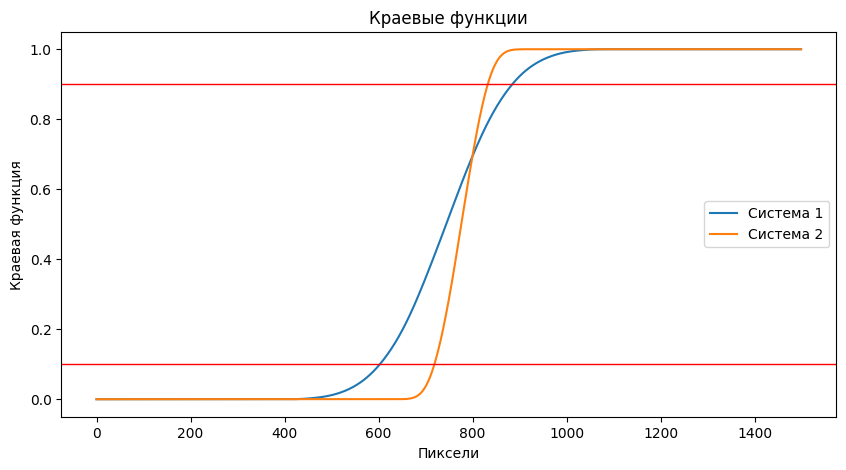

In [407]:
plt.figure(figsize=(10, 5))
plt.title("Краевые функции")
plt.plot(esf1,  label="Система 1")
plt.plot(esf2, label="Система 2")
plt.xlabel("Пиксели")
plt.ylabel("Краевая функция")
plt.axhline(y=0.9, color='r', linewidth=1)
plt.axhline(y=0.1, color='r', linewidth=1)
plt.legend()
plt.show()

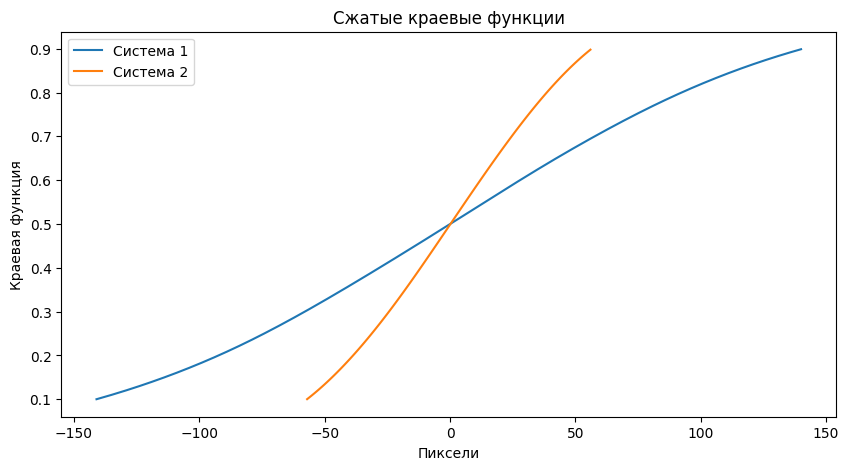

In [408]:
plt.figure(figsize=(10, 5))
plt.title("Сжатые краевые функции")
esf1, x1 = center_and_shrink_ESF(esf1)
esf2, x2 = center_and_shrink_ESF(esf2)
plt.plot(x1, esf1, label="Система 1")
plt.plot(x2, esf2, label="Система 2")
plt.xlabel("Пиксели")
plt.ylabel("Краевая функция")
plt.legend()
plt.show()

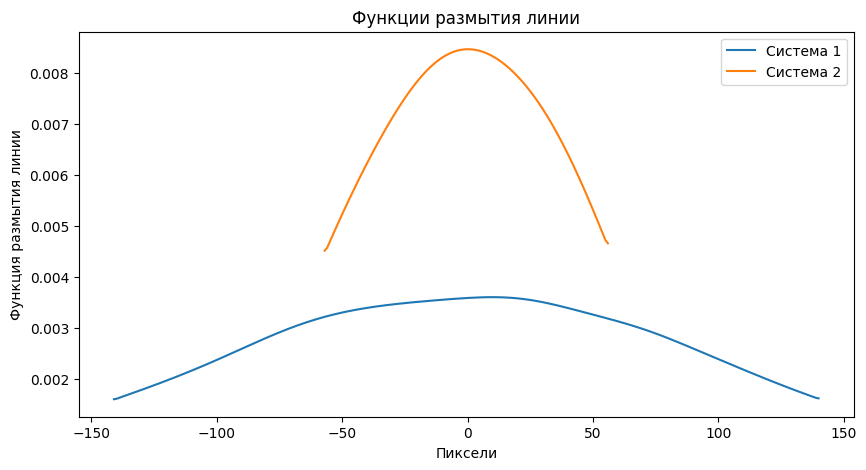

In [409]:
plt.figure(figsize=(10, 5))
plt.title("Функции размытия линии")
lsf1 = calc_LSF(esf1)
lsf2 = calc_LSF(esf2)
plt.plot(x1, lsf1, label="Система 1")
plt.plot(x2, lsf2, label="Система 2")
plt.xlabel("Пиксели")
plt.ylabel("Функция размытия линии")
plt.legend()
plt.show()

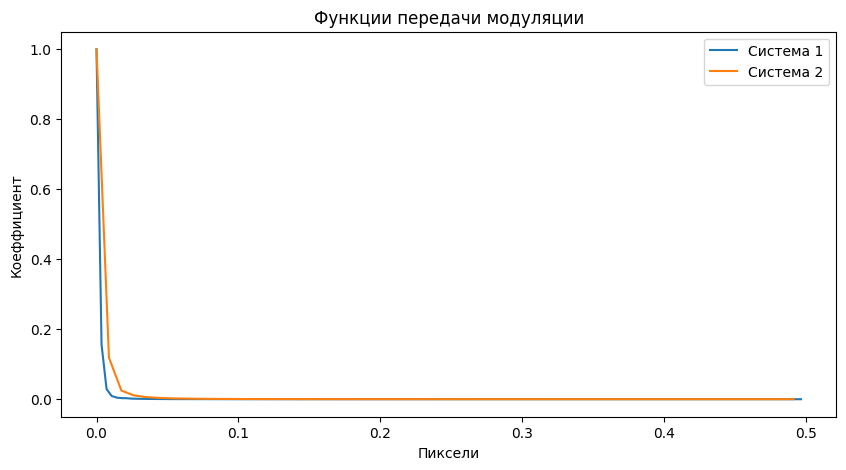

In [410]:
plt.figure(figsize=(10, 5))
plt.title("Функции передачи модуляции")
freqs1, mtf1 = calc_MTF(lsf1, x1)
freqs2, mtf2 = calc_MTF(lsf2, x2)
plt.plot(freqs1, mtf1, label="Система 1")
plt.plot(freqs2, mtf2, label="Система 2")
plt.xlabel("Пиксели")
plt.ylabel("Коеффициент")
plt.legend()
plt.show()

In [411]:
stroke_len = [10, 20, 30]

In [412]:
F_obj1 = [np.sinc(l * freqs1) for l in stroke_len]
F_obj2 = [np.sinc(l * freqs2) for l in stroke_len]

In [413]:
mtfs = [
    (freqs1, mtf1),
    (freqs2, mtf2)
]

In [414]:
def calc_F_image(F_obj, mtf, freqs, v_target):
    T_c_interp = np.interp(v_target, freqs, mtf)
    return F_obj * T_c_interp

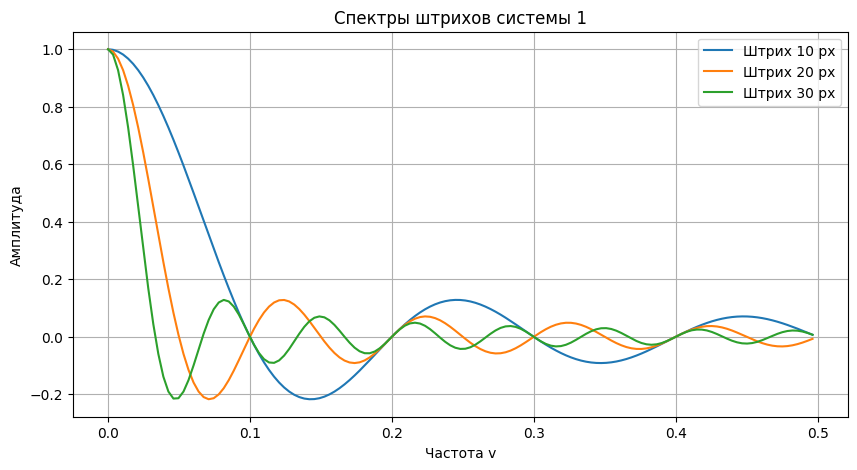

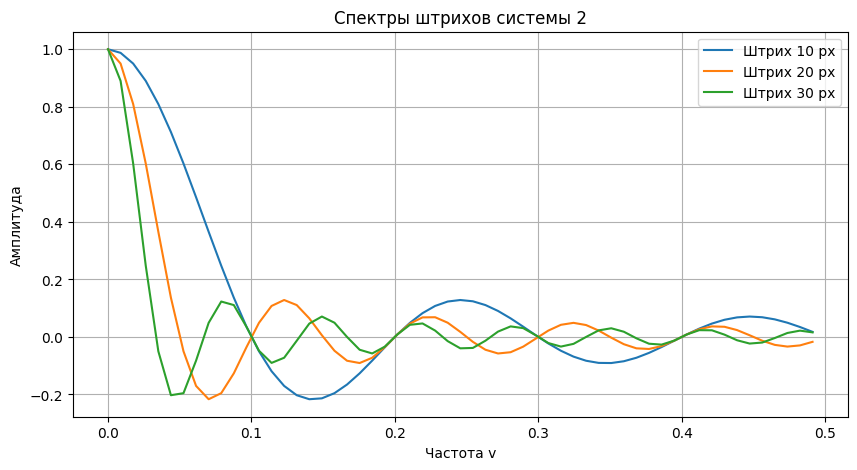

In [415]:
for sys_id, (freqs, mtf) in enumerate(mtfs):
    plt.figure(figsize=(10, 5))
    for i, l in enumerate(stroke_len):
        plt.plot(freqs, F_obj1[i] if sys_id == 0 else F_obj2[i], label=f"Штрих {l} px")
    plt.title(f"Cпектры штрихов системы {sys_id + 1}")
    plt.xlabel("Частота v")
    plt.ylabel("Амплитуда")
    plt.grid()
    plt.legend()
    plt.show()

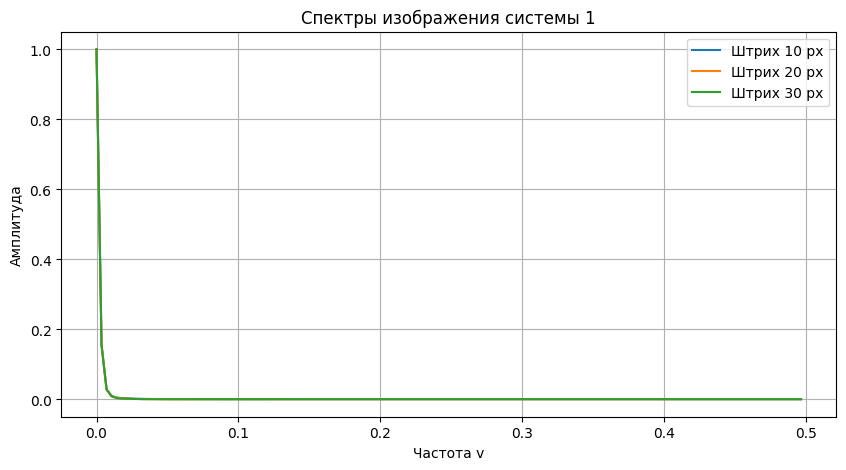

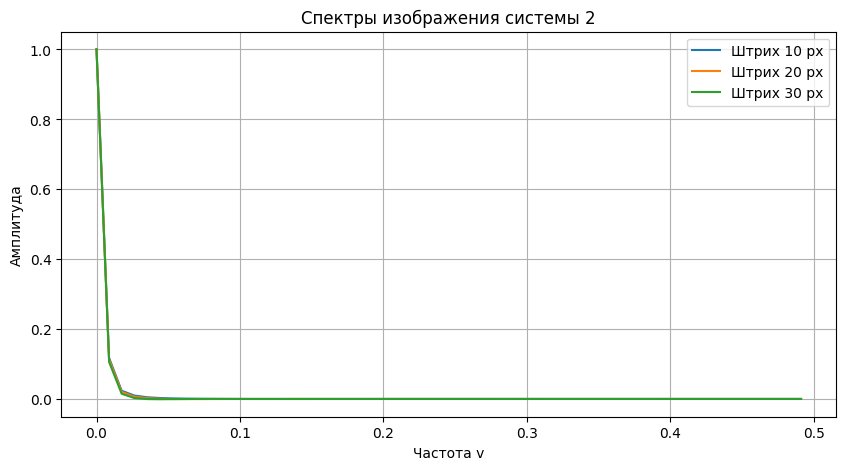

In [416]:
for sys_id, (freqs, mtf) in enumerate(mtfs):
    plt.figure(figsize=(10, 5))
    for i, l in enumerate(stroke_len):
        F_image = calc_F_image(F_obj1[i] if sys_id == 0 else F_obj2[i], mtf, freqs, freqs)
        plt.plot(freqs, F_image, label=f"Штрих {l} px")
    plt.title(f"Cпектры изображения системы {sys_id + 1}")
    plt.xlabel("Частота v")
    plt.ylabel("Амплитуда")
    plt.grid()
    plt.legend()
    plt.show()

In [417]:
def calc_edge(F_image, v):
    v3 = v / 3
    F_v3 = np.interp(v3, v, F_image)
    return (F_image + F_v3 + 2) / 4

In [418]:
def calc_combined_edge(h_x, l):
    E1 = np.roll(h_x, -l // 2)
    E2 = np.roll(h_x, l // 2)

    E_stripe = E1 + E2
    E_gap = 1 - E_stripe

    E_stripe = gaussian_filter(E_stripe, sigma=l/10)
    E_gap = gaussian_filter(E_gap, sigma=l/10)

    E_stripe = np.clip(E_stripe, 0, 2)
    E_gap = np.clip(E_gap, -1, 1)

    return E_stripe, E_gap

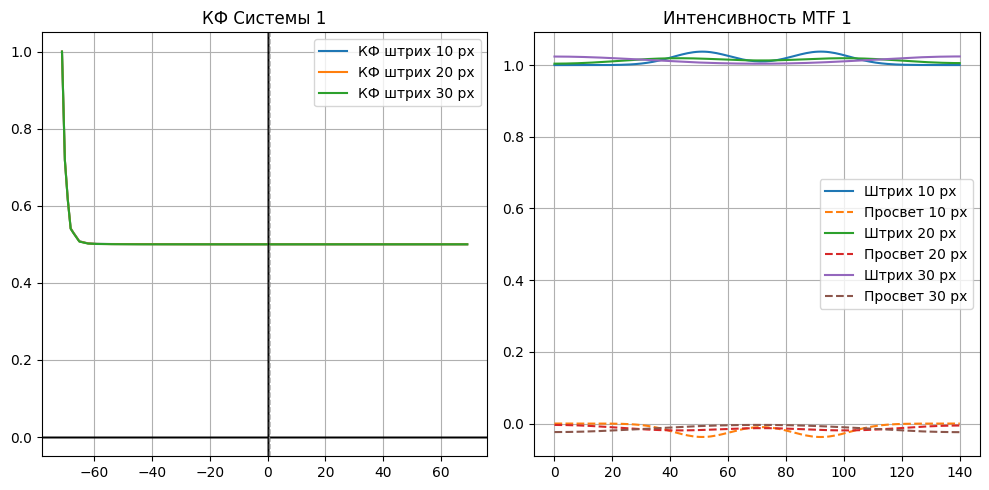

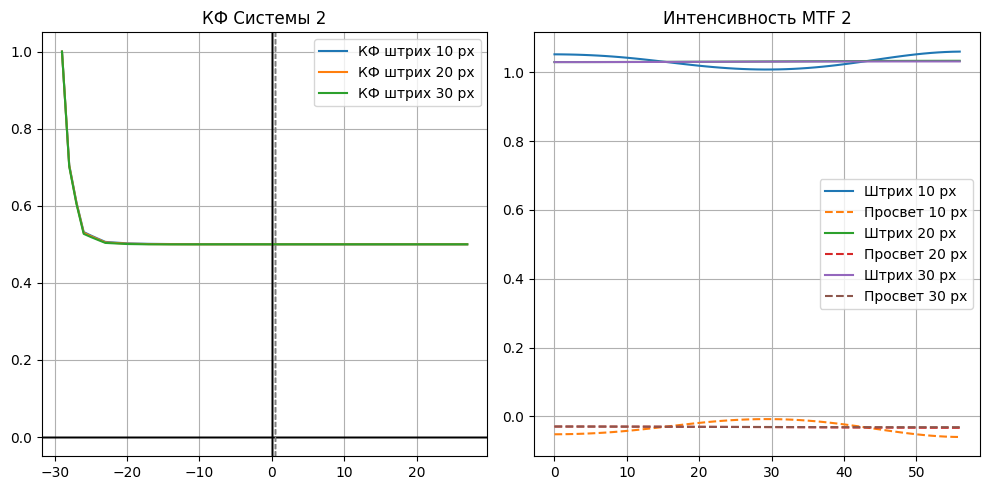

In [421]:
for sys_id, (freqs, mtf) in enumerate(mtfs):
    plt.figure(figsize=(10, 5))
    for i, l in enumerate(stroke_len):
        F_image = F_image = calc_F_image(F_obj1[i] if sys_id == 0 else F_obj2[i], mtf, freqs, freqs)
        h_x = calc_edge(F_image, freqs)
       
        E_stripe, E_gap = calc_combined_edge(h_x, 10 * l)

        plt.subplot(1, 2, 1)
        x_axis = np.arange(-len(h_x) // 2, len(h_x) // 2)
        plt.plot(x_axis, h_x, label=f"КФ штрих {l} px")
        plt.axhline(0, color='black', linewidth=1)
        plt.axvline(0, color='black', linewidth=1)
        plt.axvline(.5, color='gray', linestyle='--', linewidth=1)

        plt.subplot(1, 2, 2)
        plt.plot(E_stripe, label=f"Штрих {l} px")
        plt.plot(E_gap, linestyle='--', label=f"Просвет {l} px")
    
    plt.subplot(1, 2, 1)
    plt.title(f"КФ Системы {sys_id + 1}")
    plt.grid()
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title(f"Интенсивность MTF {sys_id+1}")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()